In [7]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn import svm

import seaborn as sns
from imblearn.over_sampling import SMOTE


import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier  # Example model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [8]:
pd.set_option('display.max_columns', None)  # Show all columns
# print(df.head())  # Display the first few rows to check the data

def csv_cleaner(path, coi):
    df = pd.read_csv(path) 

    df = df[coi]
    print(len(df))

    # Count NaNs in each column
    nan_count = df.isnull().sum()

    # Display columns with NaNs
    print(nan_count[nan_count > 0])
    print(np.max(nan_count) / len(df))

    # drop the exceptional columns that still have NaNs
    NaNx_clean = df.dropna()
    print(len(NaNx_clean))

    return NaNx_clean

def data_chooser(JorD, PorS):
    path_RData = 'gaia_matched/RANDOM_Stars_Crossmatch.csv'
    if JorD == 0: #Johnston is the holdout set
        path_HO_MDwarfs = 'gaia_matched/DESY_MDwarfs_Crossmatch.csv'
        path_HO_NotMDwarfs = 'gaia_matched/DESY_NotMDwarfs_Crossmatch.csv'
        path_MDwarfs = 'gaia_matched/JOHNSTON_MDwarfs_Crossmatch.csv'
        path_NotMDwarfs = 'gaia_matched/JOHNSTON_NotMDwarfs_Crossmatch.csv'
    elif JorD == 1: #DESY is the holdout set
        path_MDwarfs = 'gaia_matched/DESY_MDwarfs_Crossmatch.csv'
        path_NotMDwarfs = 'gaia_matched/DESY_NotMDwarfs_Crossmatch.csv'
        path_HO_MDwarfs = 'gaia_matched/JOHNSTON_MDwarfs_Crossmatch.csv'
        path_HO_NotMDwarfs = 'gaia_matched/JOHNSTON_NotMDwarfs_Crossmatch.csv'
    if PorS == 0:
        coi =  ['ra_epoch2000','dec_epoch2000','errHalfMaj','errHalfMin','errPosAng',
                'astrometric_n_good_obs_al','astrometric_gof_al',
                'astrometric_chi2_al','astrometric_excess_noise','astrometric_excess_noise_sig',
                'astrometric_params_solved','visibility_periods_used','dr2_rv_nb_transits',
                'phot_g_mean_mag_error','phot_bp_mean_mag_error','phot_rp_mean_mag_error',
                'phot_g_mean_mag_corrected','phot_g_mean_mag_error_corrected','phot_g_mean_flux_corrected',
                'phot_bp_rp_excess_factor_corrected','ra_epoch2000_error','dec_epoch2000_error',
                'ra_dec_epoch2000_corr','angDist']
    elif PorS == 1:
        coi =  ['phot_g_mean_flux', 'phot_bp_mean_flux','phot_rp_mean_flux', 'phot_bp_rp_excess_factor', 
                'bp_rp','phot_g_mean_flux_error', 'phot_bp_mean_flux_error', 'phot_g_mean_mag',
                'phot_bp_mean_mag', 'phot_rp_mean_mag','phot_g_mean_mag_error', 'phot_bp_mean_mag_error',
                'phot_rp_mean_mag_error','phot_g_mean_mag_corrected', 'phot_g_mean_mag_error_corrected',
                'phot_g_mean_flux_corrected', 'phot_bp_rp_excess_factor_corrected']
    elif PorS == 2:
        coi =  ['phot_g_mean_flux', 'phot_bp_mean_flux','phot_rp_mean_flux', 'phot_bp_rp_excess_factor', 
                'bp_rp','phot_g_mean_flux_error', 'phot_bp_mean_flux_error', 'phot_g_mean_mag',
                'phot_bp_mean_mag', 'phot_rp_mean_mag','phot_g_mean_mag_error', 'phot_bp_mean_mag_error',
                'phot_rp_mean_mag_error','phot_g_mean_mag_corrected', 'phot_g_mean_mag_error_corrected',
                'phot_g_mean_flux_corrected', 'phot_bp_rp_excess_factor_corrected',
                
                'ra_epoch2000','dec_epoch2000','errHalfMaj','errHalfMin','errPosAng',
                'astrometric_n_good_obs_al','astrometric_gof_al',
                'astrometric_chi2_al','astrometric_excess_noise','astrometric_excess_noise_sig',
                'astrometric_params_solved','visibility_periods_used','dr2_rv_nb_transits',
                'phot_g_mean_mag_error','phot_bp_mean_mag_error','phot_rp_mean_mag_error',
                'phot_g_mean_mag_corrected','phot_g_mean_mag_error_corrected','phot_g_mean_flux_corrected',
                'phot_bp_rp_excess_factor_corrected','ra_epoch2000_error','dec_epoch2000_error',
                'ra_dec_epoch2000_corr','angDist']

    MDwarfs = csv_cleaner(path_MDwarfs, coi)
    MDwarfs['SPEC'] = 'M'

    HO_MDwarfs = csv_cleaner(path_HO_MDwarfs,coi)
    HO_MDwarfs['SPEC'] = 'M'

    NotMDwarfs = csv_cleaner(path_NotMDwarfs, coi)
    NotMDwarfs['SPEC'] = 'B'

    HO_NotMDwarfs = csv_cleaner(path_HO_NotMDwarfs, coi)
    HO_NotMDwarfs['SPEC'] = 'B'

    RData = csv_cleaner(path_RData, coi)
    RData['SPEC'] = 'ND'

    length = len(RData)

    all_dat = pd.concat([MDwarfs, NotMDwarfs, RData[:int(length/2)]], axis=0)
    all_HO_dat = pd.concat([HO_MDwarfs, HO_NotMDwarfs, RData[int(length/2):]], axis=0)
    return all_dat, all_HO_dat


    

#Only gaia data which are not strings nor predominantly NaNs

all_dat, all_HO_dat = data_chooser(0, 2) 
# first number of 0 (Johnston Holdout) is always better. 
# second number can be [0: Parameter space, 1: Spectroscopy, 2: Both]

597
phot_g_mean_flux                       1
phot_bp_mean_flux                     24
phot_rp_mean_flux                     20
phot_bp_rp_excess_factor              24
bp_rp                                 24
phot_g_mean_flux_error                 1
phot_bp_mean_flux_error               24
phot_g_mean_mag                        1
phot_bp_mean_mag                      24
phot_rp_mean_mag                      20
phot_g_mean_mag_error                  1
phot_bp_mean_mag_error                24
phot_rp_mean_mag_error                20
phot_g_mean_mag_corrected              1
phot_g_mean_mag_error_corrected        1
phot_g_mean_flux_corrected             1
phot_bp_rp_excess_factor_corrected    24
phot_g_mean_mag_error                  1
phot_bp_mean_mag_error                24
phot_rp_mean_mag_error                20
phot_g_mean_mag_corrected              1
phot_g_mean_mag_error_corrected        1
phot_g_mean_flux_corrected             1
phot_bp_rp_excess_factor_corrected    24
dtype: int64

In [10]:
from sklearn.model_selection import StratifiedKFold

X = all_dat.drop(columns=['SPEC'])  # Features
y = all_dat['SPEC']  # Labels

print(y.value_counts())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# KNN classifier
knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

y_true_all = []
y_pred_all = []

# Cross-validation loop
for train_index, val_index in skf.split(X_scaled, y):
    # Split data into training and validation sets
    X_train, X_val = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    
    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
    
    # Train the model
    knn.fit(X_resampled, y_resampled)
    
    # Predict on the validation set
    y_pred = knn.predict(X_val)
    
    # Collect true labels and predictions
    y_true_all.extend(y_val)
    y_pred_all.extend(y_pred)


# Predictions
print(pd.Series(y_pred_all).value_counts())

print(f"Accuracy: {accuracy_score(y_true_all, y_pred_all)}")
print("Classification Report (Cross-Validation):")
print(classification_report(y_true_all, y_pred_all, target_names=['B', 'M', 'ND']))

SPEC
ND    32645
B      1045
M       573
Name: count, dtype: int64
ND    31386
B      1710
M      1167
Name: count, dtype: int64
Accuracy: 0.9442839214312816
Classification Report (Cross-Validation):
              precision    recall  f1-score   support

           B       0.42      0.69      0.52      1045
           M       0.32      0.65      0.43       573
          ND       1.00      0.96      0.98     32645

    accuracy                           0.94     34263
   macro avg       0.58      0.77      0.64     34263
weighted avg       0.97      0.94      0.95     34263



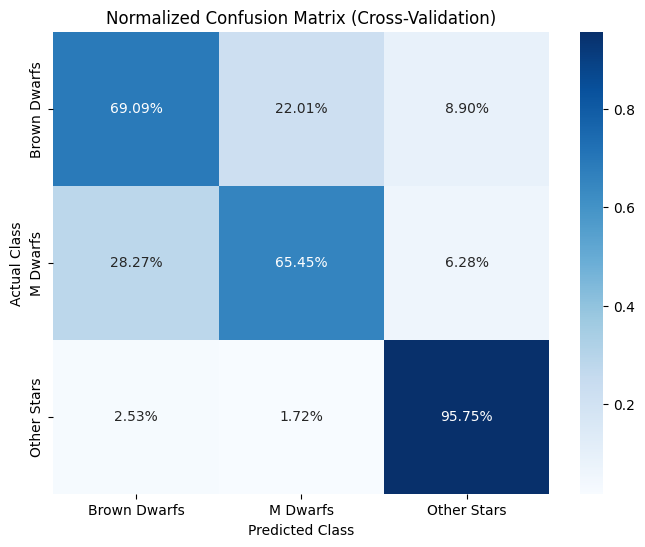

In [11]:
cm_cv = confusion_matrix(y_true_all, y_pred_all, labels=['B', 'M', 'ND'])
cm_cv_normalized = cm_cv.astype('float') / cm_cv.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cv_normalized, annot=True, fmt=".2%", cmap='Blues',
            xticklabels=['Brown Dwarfs', 'M Dwarfs', 'Other Stars'],
             yticklabels=['Brown Dwarfs', 'M Dwarfs', 'Other Stars'])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Normalized Confusion Matrix (Cross-Validation)')
plt.show()


In [12]:
# Make predictions on the holdout set
X_HO = all_HO_dat.drop(columns=['SPEC'])
y_HO = all_HO_dat['SPEC']
y_HO_pred = knn.predict(X_HO)

# Apply the same scaling as used for the main dataset
X_HO_scaled = scaler.transform(X_HO)

# Step 5: Evaluate the model on the holdout set
y_HO_pred = knn.predict(X_HO_scaled)

# Print classification report for holdout set
print("Classification Report (Holdout Set):")
print(classification_report(y_HO, y_HO_pred, target_names=['B', 'M', 'ND']))


C:\Users\smithlt\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Classification Report (Holdout Set):
              precision    recall  f1-score   support

           B       0.09      0.56      0.16       273
           M       0.27      0.20      0.23      1110
          ND       0.99      0.96      0.97     32646

    accuracy                           0.93     34029
   macro avg       0.45      0.57      0.45     34029
weighted avg       0.96      0.93      0.94     34029



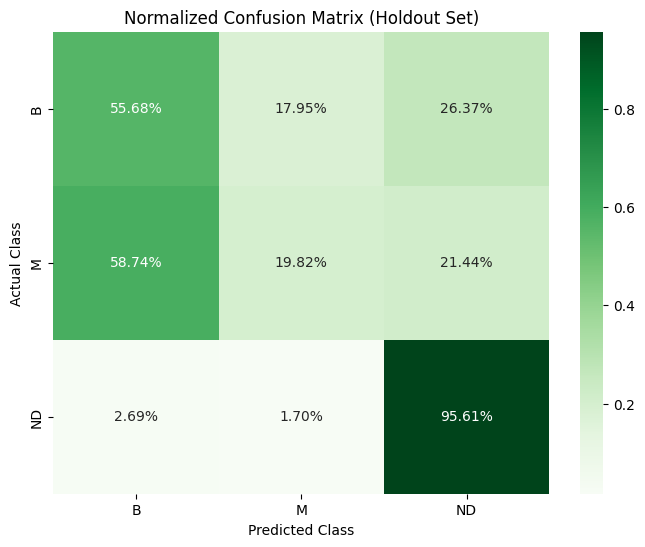

Cross-Validation Accuracy: 94.43%
Holdout Set Accuracy: 92.82%


In [14]:
# Generate and normalize confusion matrix for holdout set
cm_HO = confusion_matrix(y_HO, y_HO_pred, labels=['B', 'M', 'ND'])
cm_HO_normalized = cm_HO.astype('float') / cm_HO.sum(axis=1)[:, np.newaxis]

# Plot normalized confusion matrix for holdout set
plt.figure(figsize=(8, 6))
sns.heatmap(cm_HO_normalized, annot=True, fmt=".2%", cmap='Greens',
            xticklabels=['B', 'M', 'ND'], yticklabels=['B', 'M', 'ND'])
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Normalized Confusion Matrix (Holdout Set)')
plt.show()

cv_accuracy = accuracy_score(y_true_all, y_pred_all)
holdout_accuracy = accuracy_score(y_HO, y_HO_pred)

print(f"Cross-Validation Accuracy: {cv_accuracy:.2%}")
print(f"Holdout Set Accuracy: {holdout_accuracy:.2%}")


In [18]:
#find the mean angDist for the three datasets

#random
random_path = 'gaia_matched/RANDOM_Stars_Crossmatch.csv'
random_data = pd.read_csv(random_path)

rand_ang_dist = random_data['angDist']
mean_rand_dist = rand_ang_dist.mean()
print(f"The mean of the angular distances for the random star distribution is: {mean_rand_dist}")

#johnston mdwarfs
mdwarf_path = 'gaia_matched/JOHNSTON_MDwarfs_Crossmatch.csv'
mdwarf_data = pd.read_csv(mdwarf_path)

m_ang_dist = mdwarf_data['angDist']
mean_m_dist = m_ang_dist.mean()
print(f"The mean of the angular distances for the Johnston distribution of M-Dwarfs is: {mean_m_dist}")

#johnston non-mdwarfs
notm_path = 'gaia_matched/JOHNSTON_NotMDwarfs_Crossmatch.csv'
notm_data = pd.read_csv(notm_path)

notm_ang_dist = notm_data['angDist']
mean_notm_dist = notm_ang_dist.mean()
print(f"The mean of the angular distances for the Johnston distribution of non-MDwarfs is: {mean_notm_dist}")


The mean of the angular distances for the random star distribution is: 1.8970785372344925
The mean of the angular distances for the Johnston distribution of M-Dwarfs is: 0.635714040201005
The mean of the angular distances for the Johnston distribution of non-MDwarfs is: 0.8119922636363636
